# Классификация заболеваний легких

In [ ]:
!pip install opendatasets

In [1]:
import opendatasets as od
import shutil
import torch
from torchvision import datasets
from torch import nn
import numpy as np
from torch import optim
from torchvision import datasets
from torchvision.transforms import transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import time
import pandas as pd

## Скачивание и перенос данных

In [3]:
od.download("https://www.kaggle.com/competitions/ml-intensive-yandex-academy-spring-2024")

  7%|▋         | 66.0M/988M [02:24<33:32, 480kB/s]


KeyboardInterrupt: 

In [ ]:
def move_images_to_classes(ixs, cur_path, new_path):
    ids, targets = ixs["id"].tolist(), ixs["target_feature"].tolist()
    images = [i for i in os.listdir(cur_path) if int(i.split("_")[1][:-4]) in ids]
    for image, target in zip(images, targets):
        shutil.copyfile(rf"{cur_path}\{image}", rf"{new_path}\{target}\{image}")
    
    
ans = pd.read_csv(r"D:\ProgrammingProjects\data\train_answers.csv")
train_ix, test_ix = train_test_split(ans, train_size=0.9)
move_images_to_classes(train_ix, r"D:\ProgrammingProjects\data\train_images", r"D:\ProgrammingProjects\lungs_issues_ml\train_data")
move_images_to_classes(test_ix, r"D:\ProgrammingProjects\data\train_images", r"D:\ProgrammingProjects\lungs_issues_ml\test_data")

## Препроцессинг данных

In [118]:
from torchvision.transforms.v2 import functional as f
from core.custom_dataset import CustomDataset

In [119]:
data = CustomDataset("dataset/data/train_images", "dataset/data/train_labels.csv", 
                     transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale()
    ]))

In [151]:
def show_image(data, ix):
    x, y = data[ix]
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.title(f'y_true: {y}')
    plt.imshow(x[0], cmap="gray")
    plt.subplot(2, 2, 2)
    plt.imshow(f.adjust_sharpness(f.adjust_contrast(f.equalize(f.invert(x)), 1), 3)[0], cmap="gray")
    plt.subplot(2, 2, 3)
    plt.imshow(f.invert(x)[0], cmap="gray")
    plt.subplot(2, 2, 4)
    plt.imshow(f.adjust_sharpness(f.adjust_contrast(f.equalize(x), 1), 3)[0], cmap="gray")

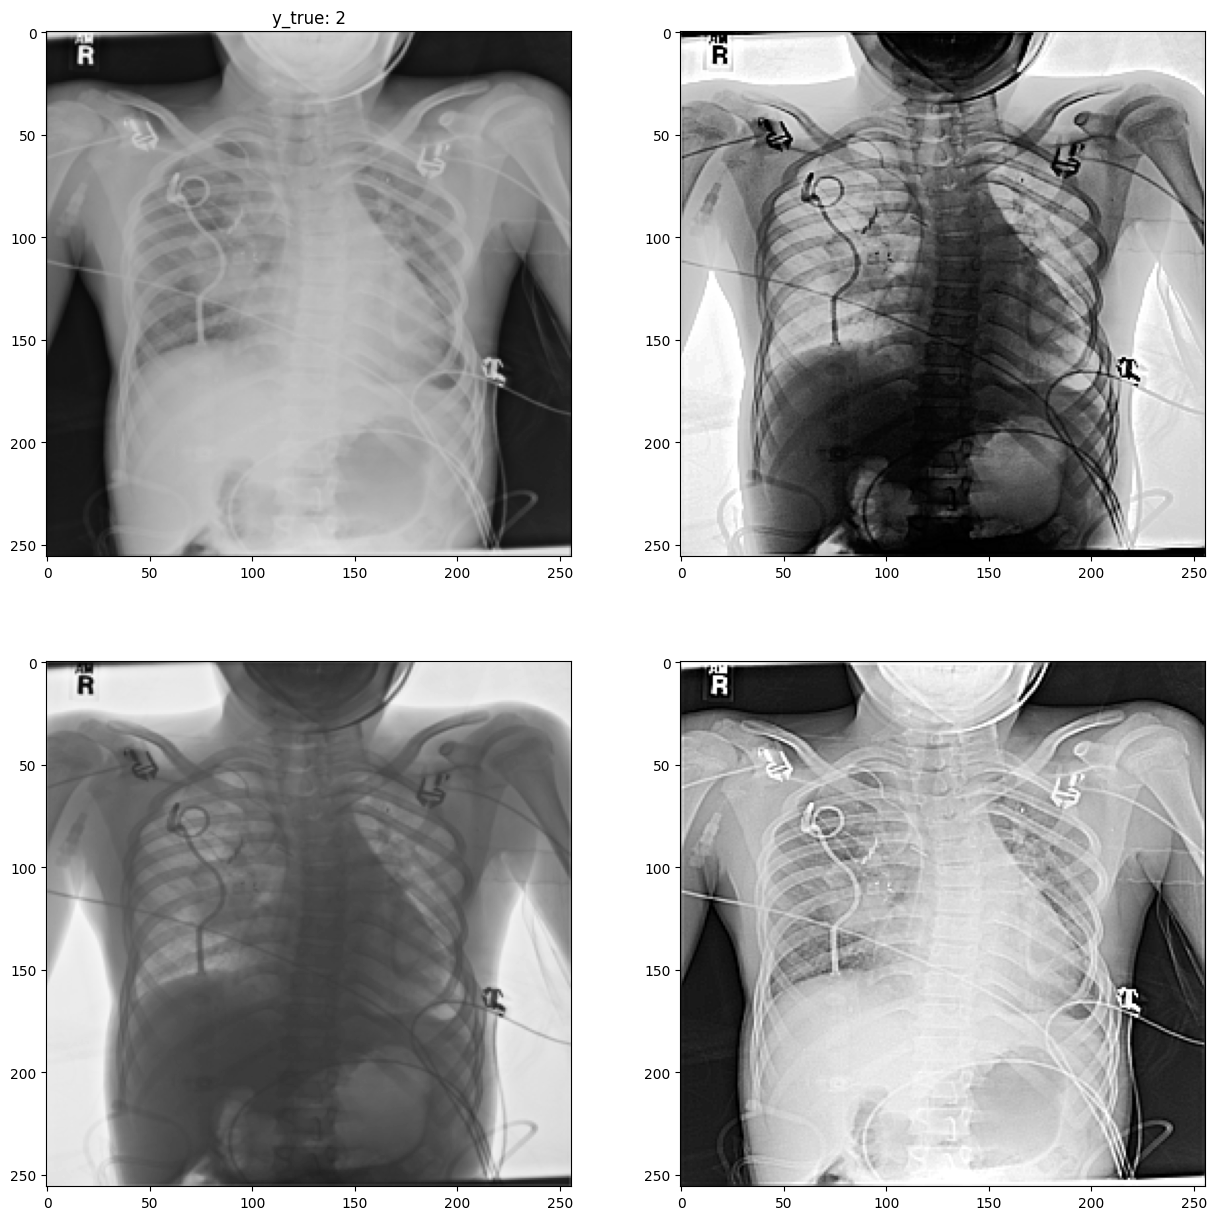

In [152]:
show_image(data, 100)

In [40]:
functional.adjust_brightness(data[0][0], 2).size(), data[0][0].size()

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

## Метрики модели

In [122]:
def get_accuracy_fscore(output, labels):
    pred = output.max(1)[1]
    return accuracy_score(labels, pred), f1_score(labels, pred, average="macro")

## Функции для построения графиков

In [123]:
def plot_data_per_epoch(fig, x, y, title="Model", log_iters=10, **kwargs):
    """Отображение данных по эпохам"""
    fig.set_title(title)
    fig.plot(x[::log_iters], y[::log_iters], **kwargs)
    fig.axvline(x[-1], c="black", linestyle="--")
    fig.hlines(y=np.mean(y), xmin=x[0], xmax=x[-1], colors="red")

In [134]:
def plot_data(fig, xs, ys, labels, title="Model", **kwargs):
    """Отображение нескольких графиков на одной картинке"""
    fig.set_title(title)
    fig.set_xticks(xs[0])
    for x, y, label in zip(xs, ys, labels):
        fig.plot(x, y, label=label, **kwargs)
    fig.legend()

In [135]:
def plot_graphs_of_education(axs, model_title, train_metrics, test_metrics, 
                             log_iters_train, log_iters_valid):
    """Построение графиков обучения с кучей данных"""
    train_it_num, train_loss, train_acc, train_fscore = np.split(np.array(train_metrics).T, [1, 2, 3])
    test_it_num, test_loss, test_acc, test_fscore = np.split(np.array(test_metrics).T, [1, 2, 3])
    plot_data_per_epoch(axs[0, 0], train_it_num[0], train_loss[0],
                            f"{model_title} train losses", log_iters_train)
    plot_data_per_epoch(axs[0, 1], train_it_num[0], train_acc[0],
                        f"{model_title} train accuracy", log_iters_train)
    plot_data_per_epoch(axs[0, 2], train_it_num[0], train_fscore[0],
                    f"{model_title} train fscore", log_iters_train)
    plot_data_per_epoch(axs[1, 0], test_it_num[0], test_loss[0],
                        f"{model_title} valid losses", log_iters_valid)
    plot_data_per_epoch(axs[1, 1], test_it_num[0], test_acc[0],
                        f"{model_title} valid accuracy", log_iters_valid)
    plot_data_per_epoch(axs[1, 2], test_it_num[0], test_fscore[0],
                        f"{model_title} valid fscore", log_iters_valid)

## Функции теста архитектуры

In [136]:
def go_for_epoch(data, batch_size, epoch_num, log_desc, model, loss_func, optimiser=None):
    if optimiser is not None:
        model.train()
    else:
        model.eval()
    ix = -1
    total_loss = 0
    total_acc = 0
    total_fscore = 0
    for x, y in tqdm(data, desc=log_desc):
        if len(y) != batch_size:
            continue
        if optimiser is not None:
            optimiser.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        if optimiser is not None:
            loss.backward()
            optimiser.step()
        ix += 1
        cur_loss, cur_acc, cur_fscore = loss.item(), *get_accuracy_fscore(y_pred, y)
        yield ix + len(data) * epoch_num, cur_loss, cur_acc, cur_fscore
        total_loss += cur_loss
        total_acc += cur_acc
        total_fscore += cur_fscore
    yield total_loss / len(data), total_acc / len(data), total_fscore / len(data)

In [143]:
def test_architecture(dataset_train, dataset_test, model, optimiser, loss_func,
                      num_epochs=3, batch_size=64, logging_iters_train=10,
                      logging_iters_valid=3, model_title="Model"):
    data_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    data_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    optimiser = optimiser(model.parameters(), lr=1e-3)
    start_time = time.time()
    TRAIN_FEATURES, VALID_FEATUES = [], []
    _, axs = plt.subplots(3, 3, figsize=(15, 10))
    for i in range(num_epochs):
        *train_metrics, train_epoch_metrics = list(go_for_epoch(
            data_train, batch_size, i, f"Epoch {i} train", model, loss_func, optimiser))
        *test_metrics, test_epoch_metrics = list(go_for_epoch(
            data_test, batch_size, i, f"Epoch {i} valid", model, loss_func))
        TRAIN_FEATURES.append(train_epoch_metrics)
        VALID_FEATUES.append(test_epoch_metrics)
        # графики обучения
        plot_graphs_of_education(axs, model_title, train_metrics, test_metrics,
                                 logging_iters_train, logging_iters_valid)
    TRAIN_FEATURES, VALID_FEATUES = np.array(TRAIN_FEATURES), np.array(VALID_FEATUES)
    for x, label in enumerate(["loss", "accuracy", "fscore"]):
        plot_data(axs[2, x], [range(num_epochs)] * 2, [TRAIN_FEATURES[:, x], VALID_FEATUES[:, x]],
                [f"Train {label}", f"Valid {label}"], title=f"{model_title} epoch {label}")
    plt.show()
    return round(time.time() - start_time)


In [144]:
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(5 * 5, 3),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.seq(x.reshape(-1, 5 * 5))

Epoch 1 valid: 100%|██████████| 43/43 [00:03<00:00, 13.77it/s]


[range(0, 2), range(0, 2)]
[1.09577907 1.09535976]
[1.07244355 1.07258433]
[range(0, 2), range(0, 2)]
[0.33490954 0.34975329]
[0.34484012 0.33829942]
[range(0, 2), range(0, 2)]
[0.24284241 0.23016674]
[0.19096409 0.21099365]


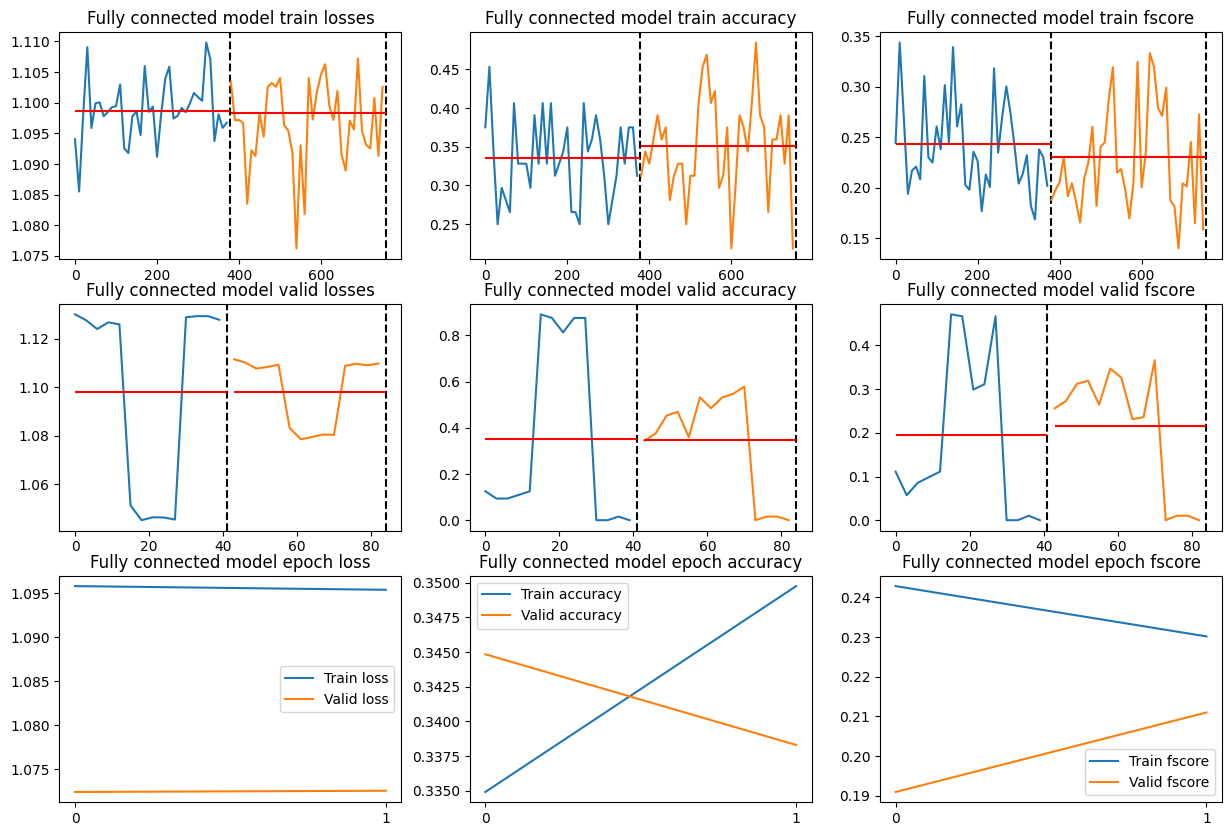

63

In [146]:
test_architecture(train_images, test_images, FullyConnectedModel(), 
                               optim.Adam, nn.CrossEntropyLoss(), 
                               model_title="Fully connected model", num_epochs=2)